# Biostat M280 Homework 2
# Sarah Ji
**Due May 11 @ 11:59PM**

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).
In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Later in the course we will learn how to derive a majorization-minimization (MM) algorithm with iterative updates
$$
	v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
	w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. Efficiency (both speed and memory) will be the most important criterion when grading this problem.


1. Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.
```julia
function nnmf(
    X::Matrix, 
    r::Int;
    maxiter::Int=1000, 
    tol::eltype(X)=1e-4,
    V::Matrix{eltype(X)}=rand(size(X, 1), r),
    W::Matrix{eltype(X)}=rand(r, size(X, 2))
    )
    # implementation
    # Output
    return V, W
end
```

0. Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  
Read in the [`nnmf-2429-by-361-face.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm()`](https://docs.julialang.org/en/stable/stdlib/io-network/#Base.DataFmt.readdlm-Tuple{Any,Char,Type,Char}) function, and display a couple sample images, e.g., using [ImageView.jl](https://github.com/JuliaImages/ImageView.jl) package.

0. Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/W0.txt)) and stopping criterion
$$
	\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

0. Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

0. (Optional) Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in part 2.

## Q1.1 Solution:

In [1]:
#using for loop
function nnmf(
    X::Matrix{T}, 
    r::Integer;
    maxiter::Integer=1000, 
    tol::Number=1e-4,
    V::Matrix{T}=rand(T, size(X, 1), r),
    W::Matrix{T}=rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    #implementation
    m, n = size(X)
    A = zeros(X)
    MR_1 = zeros(m, r)
    MR_2 = zeros(m, r)
    RR = zeros(r, r)
    RN_1 = zeros(r, n)
    RN_2 = zeros(r, n)
    A_mul_B!(A, V, W)
    A .= X .- A
    l_last = abs2(vecnorm(A, 2))

    for i in 1:maxiter
        A_mul_Bt!(MR_1, X, W)
        BLAS.syrk!('U', 'N', 1.0, W, 0.0, RR)
        V .= V .* MR_1 ./ BLAS.symm!('R', 'U', 1.0, RR, V, 0.0, MR_2)

        At_mul_B!(RN_1, V, X)
        BLAS.syrk!('U', 'T', 1.0, V, 0.0, RR)
        W .= W .* RN_1 ./ BLAS.symm!('L', 'U', 1.0, RR, W, 0.0, RN_2)

        A_mul_B!(A, V, W)
        A .= X .- A
        l_new = abs2(vecnorm(A, 2))
        if (abs(l_new - l_last) / (abs(l_last) + 1)) <= tol
            break
        end
        l_last = l_new
    end
    
    return V, W
end

nnmf (generic function with 1 method)

In [2]:
#using for loop
function nnmfOneDemo(
    X::Matrix{T}, 
    r::Integer;
    maxiter::Integer=1000, 
    tol::Number=1e-4,
    V::Matrix{T}=rand(T, size(X, 1), r),
    W::Matrix{T}=rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    #implementation
    m, n = size(X)
    A = zeros(X)
    MR_1 = zeros(m, r)
    MR_2 = zeros(m, r)
    RR = zeros(r, r)
    RN_1 = zeros(r, n)
    RN_2 = zeros(r, n)
    A_mul_B!(A, V, W)
    A .= X .- A
    l_last = abs2(vecnorm(A, 2))

    for i in 1:maxiter
        A_mul_Bt!(MR_1, X, W)
        BLAS.syrk!('U', 'N', 1.0, W, 0.0, RR)
        V .= V .* MR_1 ./ BLAS.symm!('R', 'U', 1.0, RR, V, 0.0, MR_2)

        At_mul_B!(RN_1, V, X)
        BLAS.syrk!('U', 'T', 1.0, V, 0.0, RR)
        W .= W .* RN_1 ./ BLAS.symm!('L', 'U', 1.0, RR, W, 0.0, RN_2)

        A_mul_B!(A, V, W)
        A .= X .- A
        l_new = abs2(vecnorm(A, 2))
        if (abs(l_new - l_last) / (abs(l_last) + 1)) <= tol
            println(i)
            break
        end
        l_last = l_new
    end
    
    return V, W
end

nnmfOneDemo (generic function with 1 method)

In [16]:
# using while loop
function nnmf2(
    X::Matrix{T}, 
    r::Integer;
    maxiter::Integer=1000, 
    tol::Number=1e-4,
    V::Matrix{T}=rand(T, size(X, 1), r),
    W::Matrix{T}=rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    #implementation
    m, n = size(X)
    A = zeros(X)
    MR_1 = zeros(m, r)
    MR_2 = zeros(m, r)
    RR = zeros(r, r)
    RN_1 = zeros(r, n)
    RN_2 = zeros(r, n)
    l_new = abs2(vecnorm(X - V * W, 2))
    l_last = 0.0
    count = 0
    
    while (abs(l_new - l_last) / (abs(l_last) + 1)) > tol && count < maxiter
        l_last = l_new
        count += 1
        
        A_mul_Bt!(MR_1, X, W)
        BLAS.syrk!('U','N', 1.0, W, 0.0, RR)
        V .= V .* MR_1 ./ BLAS.symm!('R', 'U', 1.0, RR, V, 0.0, MR_2)

        At_mul_B!(RN_1, V, X)
        BLAS.syrk!('U','T', 1.0, V, 0.0, RR)
        W .= W .* RN_1 ./ BLAS.symm!('L', 'U', 1.0, RR, W, 0.0, RN_2)

        A_mul_B!(A, V, W)
        A .= X .- A
        l_new = abs2(vecnorm(A, 2))
    end
    return V, W
end

nnmf2 (generic function with 1 method)

In [36]:
using BenchmarkTools
srand(1738)
@benchmark nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])

BenchmarkTools.Trial: 
  memory estimate:  9.90 MiB
  allocs estimate:  22
  --------------
  minimum time:     13.366 s (0.00% GC)
  median time:      13.366 s (0.00% GC)
  mean time:        13.366 s (0.00% GC)
  maximum time:     13.366 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

## Q1.2 Solution:

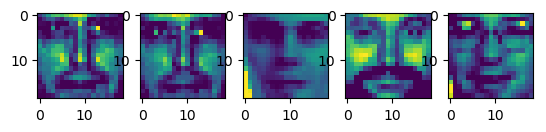

PyObject <matplotlib.image.AxesImage object at 0x1390a3690>

In [3]:
#Pkg.add("ImageView")
using ImageView
using PyPlot

X = readdlm("nnmf-2429-by-361-face.txt")
img1 = X[1,:]
img1 = reshape(img1, 19, 19)
img2 = X[2,:]
img2 = reshape(img2, 19, 19)
img3 = X[10, :]
img3 = reshape(img3, 19, 19)
img4 = X[125, :]
img4 = reshape(img4, 19, 19)
img5 = X[130, :]
img5 = reshape(img5, 19, 19)

subplot(1, 5, 1)
PyPlot.imshow(img1)
subplot(1, 5, 2)
PyPlot.imshow(img2)
subplot(1, 5, 3)
PyPlot.imshow(img3)
subplot(1, 5, 4)
PyPlot.imshow(img4)
subplot(1, 5, 5)
PyPlot.imshow(img5)

## Q1.3 Solution:

In [5]:
V0 = readdlm("V0.txt");
W0 = readdlm("W0.txt");
# with rank 10 its blurrier than with rank 50 because we are capturing less information from the original X

@time nnmf(X, 10, V = V0[:, 1:10], W = W0[1:10, :])
@time nnmf(X, 20, V = V0[:, 1:20], W = W0[1:20, :])
@time nnmf(X, 30, V = V0[:, 1:30], W = W0[1:30, :])
@time nnmf(X, 40, V = V0[:, 1:40], W = W0[1:40, :])
@time nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])

  2.881251 seconds (25 allocations: 7.331 MiB)
  3.518963 seconds (25 allocations: 7.971 MiB)
  5.916640 seconds (33 allocations: 8.614 MiB, 0.10% gc time)
  8.923399 seconds (25 allocations: 9.258 MiB)
 13.145004 seconds (26 allocations: 9.903 MiB)


([4.06515e-8 0.0239183 … 0.00502753 0.0308952; 2.06692e-5 0.0167692 … 0.00168436 0.0335739; … ; 0.0136536 0.0204076 … 8.933e-5 0.0451226; 0.0182157 0.00994188 … 5.39374e-6 0.000142989], [1.98839e-64 1.24767e-53 … 2.73192e-14 8.87992e-65; 5.00853e-27 2.38036e-26 … 2.00588e-32 4.48034e-61; … ; 3.60097e-15 2.70773e-15 … 3.86231e-22 2.41101e-44; 0.000249871 6.68716e-20 … 2.36259e-7 1.30468e-11])

## Q1.4 Solution:

For r = 50, we do not obtain the same objective value and (V, W) are not the same from that of Q1.3.

In [28]:
V_50, W_50 = nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])
V_r, W_r = nnmf(X, 50) #with random starting points

([0.00300709 0.00131677 … 0.00276287 2.49063e-38; 1.48881e-8 1.21441e-34 … 0.0163622 4.8487e-25; … ; 0.0140136 0.0120216 … 1.0555e-41 0.0362119; 0.0192426 0.00261972 … 0.0109828 0.0250265], [8.37663e-33 6.82395e-7 … 0.00160978 1.33989e-30; 2.57978e-48 4.47681e-22 … 2.46156e-14 3.16413e-78; … ; 1.51704e-35 9.67794e-21 … 4.38126e-13 1.11595e-36; 3.29248e-51 2.70439e-13 … 8.36338e-9 1.4565e-57])

In [14]:
@show Objective_Value_50 = X - (V_50 * W_50)
@show Objective_Value_random = X - (V_r * W_r)
@show L_50 = abs2(vecnorm((X - (V_50 * W_50)), 2))
@show L_random = abs2(vecnorm((X - (V_r * W_r)), 2))

L_50 = abs2(vecnorm(X - V_50 * W_50, 2)) = 4430.201581697289
L_random = abs2(vecnorm(X - V_r * W_r, 2)) = 4494.235190193085


4494.235190193085

Since the function is not a convex problem, when we optimize it from different starting points, we may get different local minimums.

## Q1.5 Solution:


In [9]:
V_ones = ones(2429, 50)
W_ones = ones(50, 361)
V_1, W_1 = nnmf(X, 50, V = V_ones, W = W_ones)

@show V_50 == V_1
@show W_50 == W_1

VW_1 = V_1*W_1 # like our new X for initial values 1
VW_50 = V_50*W_50 # X = VW with first 50 columns and 50 rows 

@show L_one = abs2(vecnorm((X - (V_1 * W_1)), 2))
@show L_50 = abs2(vecnorm((X - (V_50 * W_50)), 2))

V_50 == V_1 = false
W_50 == W_1 = false
L_one = abs2(vecnorm(X - V_1 * W_1, 2)) = 25297.01651108185
L_50 = abs2(vecnorm(X - V_50 * W_50, 2)) = 4430.201581697289


4430.201581697289

In [11]:
VW_1

2429×361 Array{Float64,2}:
 0.101271   0.1261    0.139962  0.129834  …  0.171626  0.152778  0.116491
 0.100649   0.125325  0.139103  0.129037     0.170572  0.15184   0.115775
 0.101952   0.126948  0.140904  0.130708     0.172781  0.153806  0.117275
 0.0977756  0.121747  0.135131  0.125353     0.165702  0.147505  0.11247 
 0.100859   0.125587  0.139393  0.129306     0.170928  0.152156  0.116017
 0.0983313  0.122439  0.135899  0.126066  …  0.166644  0.148343  0.113109
 0.096265   0.119867  0.133044  0.123417     0.163142  0.145226  0.110733
 0.0930882  0.115911  0.128653  0.119344     0.157759  0.140434  0.107078
 0.0892397  0.111119  0.123334  0.11441      0.151236  0.134628  0.102651
 0.0886539  0.110389  0.122525  0.113659     0.150244  0.133744  0.101978
 0.101289   0.126122  0.139987  0.129857  …  0.171656  0.152805  0.116511
 0.0996033  0.124023  0.137657  0.127696     0.1688    0.150263  0.114573
 0.101862   0.126836  0.140779  0.130592     0.172628  0.15367   0.117171
 ⋮         

In [35]:
nnmfOneDemo(X, 50, V = V_ones, W = W_ones)

1


([0.00547467 0.00547467 … 0.00547467 0.00547467; 0.00544139 0.00544139 … 0.00544139 0.00544139; … ; 0.00570408 0.00570408 … 0.00570408 0.00570408; 0.00560619 0.00560619 … 0.00560619 0.00560619], [0.369952 0.46066 … 0.558078 0.42552; 0.369952 0.46066 … 0.558078 0.42552; … ; 0.369952 0.46066 … 0.558078 0.42552; 0.369952 0.46066 … 0.558078 0.42552])

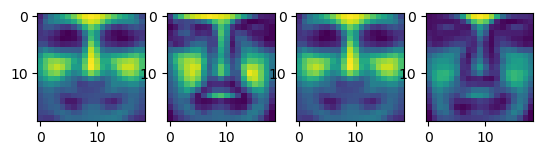

PyObject <matplotlib.image.AxesImage object at 0x12e15d390>

In [10]:
subplot(1, 4, 1)
PyPlot.imshow(reshape(VW_1[1, :], 19, 19))
subplot(1, 4, 2)
PyPlot.imshow(reshape(VW_50[1, :], 19, 19))
subplot(1, 4, 3)
PyPlot.imshow(reshape(VW_1[12, :], 19, 19))
subplot(1, 4, 4)
PyPlot.imshow(reshape(VW_50[12, :], 19, 19))

This is the average american face thats in VW_1 LOL

Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$

When we give the initial values of ones, it stops after only one iteration, because the updates for V and W from the first iteration will be close to the last due to mean and variance of the original X matrix given. 

Note that when we plot the rows of the VW_1, we only get one face. That is, each row contains data which maps to the same one person's face. 

## Q1.6 Solution:

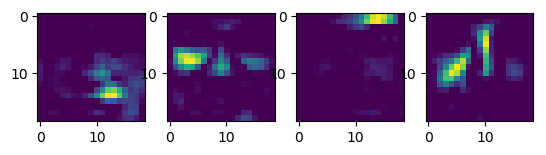

PyObject <matplotlib.image.AxesImage object at 0x14bea7350>

In [40]:
V, W = nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])

W_img1 = W[1, :]
W_img1 = reshape(W_img1, 19, 19)

W_img2 = W[2, :]
W_img2 = reshape(W_img2, 19, 19)

W_img5 = W[9, :]
W_img5 = reshape(W_img5, 19, 19)

W_img10 = W[10, :]
W_img10 = reshape(W_img10, 19, 19)

#VW = V*W
subplot(1, 4, 1)
PyPlot.imshow(W_img1)
subplot(1, 4, 2)
PyPlot.imshow(W_img2)
subplot(1, 4, 3)
PyPlot.imshow(W_img5)
subplot(1, 4, 4)
PyPlot.imshow(W_img10)

Above, we plot the basis images (rows of  W) at rank  r = 50. 

Note that from the first row, we see a glimpse of the image of the upper lip of an individual's face.
From the second row, we see what appears to be the right cheekbone of an individual's face. 
From the ninth row, we see what appears to be the forehead of an individual's face. 
From the tenth row, we see what appears to be the nose bridge and right cheekbone of an individual's face. 

## Q2. Linear Mixed Models

Consider a linear mixed effects model
$$
	y_i = \mathbf{x}_i^T \beta + \mathbf{z}_i^T \gamma + \epsilon_i, \quad i=1,\ldots,n,
$$
where $\epsilon_i$ are independent normal errors $N(0,\sigma_0^2)$, $\beta \in \mathbb{R}^p$ are fixed effects, and $\gamma \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$) independent of $\epsilon_i$. 

0. Show that 
$$
    \mathbf{y} \sim N \left( \mathbf{X} \beta, \sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T \right),
$$
where $\mathbf{y} = (y_1, \ldots, y_n)^T \in \mathbb{R}^n$, $\mathbf{X} = (\mathbf{x}_1, \ldots, \mathbf{x}_n)^T \in \mathbb{R}^{n \times p}$, and $\mathbf{Z} = (\mathbf{z}_1, \ldots, \mathbf{z}_n)^T \in \mathbb{R}^{n \times q}$. 

0. Write a function, with interface 
    ```julia
    logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number),
    ```
that evaluates the log-density of a multivariate normal with mean $\mathbf{0}$ and covariance $\sigma_0^2 \mathbf{I} + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T$ at $\mathbf{y}$. Make your code efficient in the $n \gg q$ case. 

0. Compare your result (both accuracy and timing) to the [Distributions.jl](http://distributionsjl.readthedocs.io/en/latest/multivariate.html#multivariate-normal-distribution) package using following data.  
    ```julia
    using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
    @show logpdf_mvn(y, Z, σ0, σ1)
    @show logpdf(mvn, y)

    # benchmark
    @benchmark logpdf_mvn(y, Z, σ0, σ1)
    @benchmark logpdf(mvn, y)
    ```

## Q2.1 Solution:

$${f(\mathbf{y}) = \frac1{sqrt(2\pi))^p|\mathbf{\Sigma}|^{1/2}}} * e^{-(\mathbf{y}-\mathbf{\mu})^{T}\mathbf{\Sigma}^{-1}(\mathbf{y}-\mu)/2}$$ 
<br>
>Take the log of both sides to get the log pdf:

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}log|\mathbf{\Sigma}| - \frac{[(\mathbf{y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{y}-\mathbf{\mu})]}{2}$$
<br>

>Now, we use the Woodbury Formula. Let $\mathbf{A} = \sigma_0^{2}\mathbf{I}$ and $\mathbf{U} = \mathbf{V} = \sigma_1\mathbf{Z}$
<br>
Using the Woodbury Formula and properties of determinants of block matrices, we can plug in $\mathbf{|\Sigma|}$ and $\mathbf{\Sigma^{-1}}$ as follows into the logpdf:
<br>

$$\mathbf{\Sigma^{-1}} = ({\sigma_0^{2}}\mathbf{I} + \sigma_1^{2}\mathbf{Z{Z}^{T}})^{-1} = \sigma_0^{2}\mathbf{I} - \sigma_0^{-4}\sigma_1^{2}*\mathbf{Z}* (\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})$$
<br>
 
$$\mathbf{|\Sigma|} = det({\sigma_0^{2}}\mathbf{I} + \sigma_1^{2}\mathbf{Z{Z}^{T}}) = det({\sigma_0^{2}}\mathbf{I}) * det(\mathbf{I} + \sigma_0^{-2}\sigma_1^{2}\mathbf{Z^{T}Z}) = {\sigma_0^{2n}} * (\mathbf{I} + \sigma_0^{-2}\sigma_1^{2}\mathbf{Z^{T}Z})$$

<br>
$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}log|\mathbf{\Sigma}| - \frac{[(\mathbf{y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{y}-\mathbf{\mu})]}{2}$$
<br>

>where we note that: log|$\mathbf{\Sigma}|$ = 2 * n * log(σ0) + logdet($\mathbf{I}$ + $\sigma_0^{-2}$*$\sigma_1^{2}\mathbf{Z^{T}Z}$))
<br>

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}*(2 * n * log(σ0) + logdet(\mathbf{I} + $\sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})) - \frac{[(\mathbf{y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{y}-\mathbf{\mu})]}{2}$$
<br>

>Since we are given that $\mathbf{\mu}$ = 0, we can rewrite the log-pdf as:

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}*(2 * n * log(σ0) + logdet(\mathbf{I} + $\sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})) - \frac{[(\mathbf{y})^T\mathbf{\Sigma}^{-1}(\mathbf{y})]}{2}$$
<br>

>Substituting in $\mathbf{\Sigma^{-1}}$ we have:

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}*(2 * n * log(σ0) + logdet(\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})) - \frac{[(\mathbf{y})^T(\sigma_0^{-2}\mathbf{I} - \sigma_0^{-4}*\sigma_1^{2}*\mathbf{Z}(\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z}))(\mathbf{y})]}{2}$$
<br>

>Now distributing out the $y$ and $y^T$ we get:

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}*(2 * n * log(σ0) + logdet(\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})) - \frac{(\mathbf{y})^T(\sigma_0^{-2})\mathbf{y}}{2} + (\frac{\sigma_1}{\sigma_0^{2}}\mathbf{{y}^{T}Z})(\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})(\mathbf{{Z}^{T}}\mathbf{y}\frac{\sigma_1}{\sigma_0^{2}})$$

>Thus, we write the function below, utilizing symmetric and positive definite structure of $\mathbf{\Sigma} = (\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})$ through Cholesky Decomposition. We then can use this decomposition to speed up efficiency and reduce our benchmarking run time, when computing the determinant or solving the linear system of equations in the last term.

>Now we we will show that the variance evaluates the variance of the log-density of a multivariate normal with mean 0 and and covariance matrix $\mathbf{\Sigma} = (\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})$<br>
<br>
>First we start by showing that the mean of $\mathbf{y}$ is $\mathbf{0}$:
$$\mathbf{y} = \mathbf{X} \mathbf{\beta} + \mathbf{Z}^T \mathbf{\gamma} + \mathbf{\epsilon}$$
<br>
$$E[\mathbf{y}] = E[\mathbf{X} \beta + \mathbf{Z}^T \mathbf{\gamma} + \mathbf{\epsilon}]$$
<br>
$$E[\mathbf{y}] = E[\mathbf{X} \beta] + E[\mathbf{Z}^T \mathbf{\gamma}] + E[\mathbf{\epsilon}]$$
<br>
$$E[\mathbf{y}] = E[\mathbf{X}]\mathbf{\beta} + \mathbf{Z}^TE[\mathbf{\gamma}] + E[\mathbf{\epsilon}]$$
<br> 
>Recall that we are given that $\epsilon_i$ are independent normal errors $N(\mathbf{0},\sigma_0^2)$, $\beta \in \mathbb{R}^p$ are fixed effects, and $\mathbf{\gamma} \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$) independent of $\epsilon_i$. Then plugging in $E[\mathbf{\gamma}] = \mathbf{0}$ and $E[\mathbf{\epsilon}] = \mathbf{0}$, we get:
<br>
$$E[\mathbf{y}] = E[\mathbf{X}]\mathbf{\beta} + \mathbf{Z}^T[\mathbf{0}] + [\mathbf{0}]$$
>And then we make note of the fact that X is a matrix of fixed effects, so we get:
$$E[\mathbf{y}] = \mathbf{X}\mathbf{\beta}$$
<br>

>Now we we will show that the covariance of y evaluates to $\mathbf{\Sigma} = (\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})$
<br>
$$Var(\mathbf{y}) = Var(\mathbf{X} \beta + \mathbf{Z}^T \mathbf{\gamma} + \mathbf{\epsilon})$$
<br>
$$Var(\mathbf{y}) = Var(\mathbf{X} \beta) + Var(\mathbf{Z}^T \mathbf{\gamma}) + Var(\mathbf{\epsilon})$$
<br>
>Now, making note of the fact that $Var(\mathbf{X}\mathbf{\beta}) = 0$, since $\mathbf{\beta}$ and $\mathbf{X}$ are fixed constants, we get:
$$Var(\mathbf{y}) = 0 + \mathbf{Z}^TVar(\mathbf{\gamma})\mathbf{Z} + Var(\mathbf{\epsilon})$$
<br>
>Now plugging in $Var(\mathbf{\gamma}) = \sigma_1^2 \mathbf{I}_q$ and $Var(\mathbf{\epsilon}) = \sigma_0^2$ we get:
<br>
$$Var(\mathbf{y}) = \mathbf{Z}^T(\sigma_1^2 \mathbf{I}_q)\mathbf{Z} + \sigma_0^2(\mathbf{I})$$
<br>
$$Var(\mathbf{y}) = \mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z}$$

In [13]:
# better memory efficiency
function logpdf_mvn0(y::Vector, Z::Matrix, σ0::Number, σ1::Number)
    n = length(y)
    Σchol = cholfact!(σ1^2/σ0^2 * (Z' * Z) + I) 
    logdetΣchol = 2 * n * log(σ0) + logdet(Σchol)
    - (n//2) * log(2π) - (1//2) * logdetΣchol - (1//2) * (sum(abs2, y)/σ0^2 - sum(abs2, Σchol[:L] \ ((Z' * y) * (σ1/σ0^2))))
end

logpdf_mvn0 (generic function with 1 method)

In [22]:
using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
@show logpdf_mvn0(y, Z, σ0, σ1)
@show logpdf(mvn, y)

logpdf_mvn0(y, Z, σ0, σ1) = -1571.5736734653365
logpdf_mvn1(y, Z, σ0, σ1) = -1571.5736734653365
logpdf(mvn, y) = -1571.5736734654135


-1571.5736734654135

In [24]:
# benchmark
@benchmark logpdf_mvn0(y, Z, σ0, σ1)

BenchmarkTools.Trial: 
  memory estimate:  4.17 KiB
  allocs estimate:  16
  --------------
  minimum time:     39.341 μs (0.00% GC)
  median time:      59.602 μs (0.00% GC)
  mean time:        64.492 μs (0.73% GC)
  maximum time:     3.007 ms (94.80% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [23]:
# benchmark
@benchmark logpdf_mvn1(y, Z, σ0, σ1)

BenchmarkTools.Trial: 
  memory estimate:  4.20 KiB
  allocs estimate:  17
  --------------
  minimum time:     56.461 μs (0.00% GC)
  median time:      82.334 μs (0.00% GC)
  mean time:        83.138 μs (0.72% GC)
  maximum time:     3.182 ms (94.61% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [25]:
@benchmark logpdf(mvn, y)

BenchmarkTools.Trial: 
  memory estimate:  15.78 KiB
  allocs estimate:  3
  --------------
  minimum time:     4.405 ms (0.00% GC)
  median time:      6.361 ms (0.00% GC)
  mean time:        6.428 ms (0.00% GC)
  maximum time:     8.186 ms (0.00% GC)
  --------------
  samples:          775
  evals/sample:     1

In [12]:
6.362/.038693

164.42250536272712